In [108]:
import pandas as pd
import numpy as np
from scipy.cluster.vq import kmeans,vq,whiten

In [109]:
df = pd.read_csv('HealthViz County Dataset 6 21 17.csv', skiprows=0, header=1, index_col=0, encoding = "ISO-8859-1")
df.index.name=None

In [110]:
df.dropna(axis=0, how='any', inplace=True)
df_county = df[['County']] # dataframe has the geo information
df.drop(df.columns[[0]], axis=1, inplace=True) #drop 'County'

In [111]:
### Split dataframe into different levels based on the population ###
def split_df(df, num, col_population):
    '''
    Split dataframe into desired number of groups based on the population
        num: int
        col_population: string, e.g 'Population (residents), 2011-2015'
        
        return: a list of sub dataframes
    '''
    rows, cols = df.shape
    size = int(round(rows/num, 0))
    df = df.sort_values(col_population, ascending=True)
    l = []
    for g, df in df.groupby(np.arange(len(df)) // size):
        l = l + [df]
    if len(l) > num:
        df1 = l[-1]
        df2 = l[-2]
        df3 = df2.append(df1)
        l = l[: -2]
        l = l + [df3]
    return l


In [112]:
# for check
l = split_df(df, 10, 'Population (residents), 2011-2015')
for i in l:
    print(i.shape)

(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(250, 17)


In [113]:
# elbow effect to choose K in K-means
# sum of squared error (SSE): sum of the squared distance between each member of the cluster and its centroid

### Get K function ###
def get_k(df, size):
    '''
    Using the size of each cluster to determine the number of clusters, which is K
        size: int
    '''
    rows, cols = df.shape
    k = int(round(rows/size, 0))
    return k


### Check K ###
from scipy.cluster.vq import kmeans,vq,whiten
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def check_k(df, k, graph_range):
    '''
    range(1, 100)
    '''
    a,b = graph_range
    K = range(a,b)
    X = whiten(df)
    KM = [kmeans(X,k) for k in K]
    centroids = [cent for (cent,var) in KM]
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    #cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]
    l = []
    for i in range(a-1, b-2):
        rate = abs(avgWithinSS[i+1] - avgWithinSS[i])/avgWithinSS[i]
        l = l + [rate]
    k_changing_rate = l[k-2]
    
    kIdx = k-1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None') #K[kIdx] [kIdx]
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    return k_changing_rate

K is 12


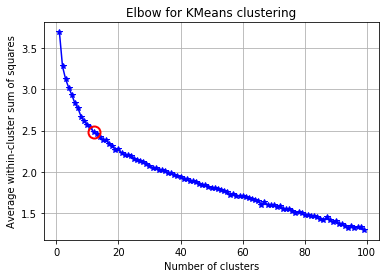

0.023613755810902668

In [114]:
df1 = l[0] # get a subset
k = get_k(df1, 20) # decide the size to be around 20
print ('K is', k)

### check k ###
graph_range = (1,100) # decide the check-k graph range
check_k(df1, k, graph_range)

In [115]:
### get the K-means clustering table ###
from sklearn.cluster import KMeans
import numpy as np
def get_k_means(df,k):
    X = whiten(df)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    df['label'] = kmeans.labels_.tolist()
    return df

def get_table(df, k):
    l = []
    label = []
    d = {}
    for i in range(0,k):
        group = df['label'] == i
        data = df[group]
        index = data.index.tolist()
        #print (index)
        l.append(index)
        label += [i]
    d['label'] = label
    d['ID'] = l
    table = pd.DataFrame(data=d)
    return (table, l)

def get_kmeans_table(df, df_county, k):
    data = get_k_means(df, k)
    table, l = get_table(data, k)
    new_df = pd.merge(df, df_county, left_index=True, right_index=True)
    county_l = []
    for i in l:
        name_l = new_df.ix[i]['County'].values.tolist()
        county_l.append(name_l)
    se = pd.Series(county_l)
    table['county name'] = se.values
    return table

In [116]:
### example for the small population counties ###
get_kmeans_table(df1, df_county, 12)

/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,ID,label,county name
0,"[35033, 13249, 48107, 40033, 30005, 51530, 480...",0,"[Mora County, NM, Schley County, GA, Crosby Co..."
1,[2170],1,"[Matanuska-Susitna Borough, AK]"
2,"[48495, 48501, 4011, 40085, 48369, 49023, 4839...",2,"[Winkler County, TX, Yoakum County, TX, Greenl..."
3,"[20197, 18171, 21143, 19051, 40151, 31039, 310...",3,"[Wabaunsee County, KS, Warren County, IN, Lyon..."
4,"[54105, 48207, 51021, 21181, 54013, 54073, 471...",4,"[Wirt County, WV, Haskell County, TX, Bland Co..."
5,"[8025, 37095, 13259, 8011, 21075, 47067, 21129...",5,"[Crowley County, CO, Hyde County, NC, Stewart ..."
6,"[46109, 27155, 46045, 30071, 38103, 46053, 311...",6,"[Roberts County, SD, Traverse County, MN, Edmu..."
7,"[26131, 54093, 54071, 29057, 29041, 41037, 311...",7,"[Ontonagon County, MI, Tucker County, WV, Pend..."
8,"[13283, 51036, 13243, 28009, 48405, 13165, 450...",8,"[Treutlen County, GA, Charles City County, VA,..."
9,"[38085, 46041, 31173, 51620, 46121, 28143]",9,"[Sioux County, ND, Dewey County, SD, Thurston ..."


In [118]:
### example for the large population counties ###
df_large = l[-1]

In [134]:
### preprocess data
df_large.drop(['Population (residents), 2011-2015', 'Population, Non-Hispanic Black (residents), 2011-2015', 'Population, Hispanic or Latino (residents), 2011-2015',\
              'Population, Asian or Pacific Islander (residents), 2011-2015','Total election votes (Presidential) (votes), 2016'],inplace=True,axis=1)

def get_log(df, l):
    '''
    Get the log values of certain dollar related variables, with the input of a list of variable names
        l: a list of strings (variable name)
    '''
    for i in l:
        data = df[[i]]
        array = np.log(data.values)
        data = pd.DataFrame(array, columns=data.columns, index=data.index)
        df[i] = data[i]
    return df

df_large = get_log(df_large, ['Median household income, 2011-2015'])

In [138]:
get_kmeans_table(df_large, df_county, 12)

/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,ID,label,county name
0,"[48061, 48215, 48141]",0,"[Cameron County, TX, Hidalgo County, TX, El Pa..."
1,"[13051, 29077, 26065, 48303, 21067, 37051, 370...",1,"[Chatham County, GA, Greene County, MO, Ingham..."
2,"[18057, 24027, 8035, 8013, 34035, 51107, 34027...",2,"[Hamilton County, IN, Howard County, MD, Dougl..."
3,"[33015, 17111, 8069, 51087, 36087, 51041, 2918...",3,"[Rockingham County, NH, McHenry County, IL, La..."
4,"[6087, 23005, 36001, 34021, 6083, 6097, 27123,...",4,"[Santa Cruz County, CA, Cumberland County, ME,..."
5,"[17119, 42043, 9011, 6079, 34015, 36027, 42095...",5,"[Madison County, IL, Dauphin County, PA, New L..."
6,"[34001, 42049, 17201, 45051, 45083, 12097, 390...",6,"[Atlantic County, NJ, Erie County, PA, Winneba..."
7,"[29510, 22071, 24510, 34013, 36005, 42101, 261...",7,"[St. Louis city, MO, Orleans Parish, LA, Balti..."
8,"[41047, 26049, 6107, 6099, 6077, 6029, 6019, 6...",8,"[Marion County, OR, Genesee County, MI, Tulare..."
9,"[12073, 37063, 26161, 55025, 11001, 8031, 3401...",9,"[Leon County, FL, Durham County, NC, Washtenaw..."


In [139]:
d = get_kmeans_table(df_large, df_county, 12)
print(d.to_dict())

{'ID': {0: [13051, 29077, 26065, 48303, 21067, 37051, 37067, 18003, 45019, 5119, 45079, 6053, 6083, 47093, 22033, 45045, 20173, 37081, 31055, 40143, 47037, 1073, 35001, 29095, 40109, 21111, 39061, 12031, 18097, 47157, 55079, 37119, 4019, 39049, 12095, 12057, 48029, 48439, 32003, 48113, 4013, 48201, 17031, 6037], 1: [18057, 24027, 8035, 8013, 34035, 51107, 24031, 51059, 25017], 2: [17119, 34001, 42049, 17201, 45051, 45083, 12097, 39093, 12033, 42079, 47065, 48355, 41039, 42129, 39151, 4021, 42011, 1097, 22051, 39095, 25013, 12101, 53063, 18089, 12127, 34031, 39113, 39153, 12105, 44007, 26099, 39035, 6067, 6065], 3: [29510, 22071, 24510, 34017, 25025, 41051, 34013, 42101, 36047, 12086], 4: [41047, 26049, 6107, 6099, 6077, 6029, 6019, 26163, 6071], 5: [12111, 12069, 12083, 12021, 12081, 12115, 12009, 34029, 12071, 12103, 12099], 6: [36027, 33015, 17111, 8069, 51087, 51041, 6061, 29183, 55133, 33011, 27037, 51153, 51810, 34005, 48491, 8059, 24003, 42017, 48157, 17197, 13067, 48121, 34023, 

/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
